In [1]:
library(hise)
library(ggh4x)
library(ggplot2)
library(stats)
library(parallel)
library(dplyr)
library(readxl)
library(tidyverse)
library(rstatix)
library(ggpubr)
library(corrplot)

Loading required package: ggplot2

Warning message:
“package ‘dplyr’ was built under R version 4.3.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘readxl’ was built under R version 4.3.3”
Warning message:
“package ‘tidyverse’ was built under R version 4.3.3”
Warning message:
“package ‘tibble’ was built under R version 4.3.3”
Warning message:
“package ‘tidyr’ was built under R version 4.3.3”
Warning message:
“package ‘readr’ was built under R version 4.3.3”
Warning message:
“package ‘purrr’ was built under R version 4.3.3”
Warning message:
“package ‘stringr’ was built under R version 4.3.3”
Warning message:
“package ‘forcats’ was built under R version 4.3.3”
Warning message:
“package ‘lubridate’ was built under R version 4.3.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──

In [2]:
meta_data<-read.csv("/home/workspace/IHA_Figure_Revision/Figure4/00_Flu_Year_Specific_Meta_Data/meta_data.csv")


In [3]:
df_MSD<-read.csv("/home/workspace/IHA_Figure_Revision/Figure4/02_Total_IgG_MSD_Assay/MSD_All.csv")
df_MSD<-df_MSD[c("Sample.Kit.Barcode","Assay","Mean","Calc..Conc..Mean","subject.biologicalSex",
             'cohort.cohortGuid', 'subjectGuid','CMV','Flu_Year','Flu_Day','Visit_Type','Year_N','Visit_Flu_Year')]

In [4]:
file_list<-list.files("/home/workspace/IHA_Figure_Revision/Dataset/MSD/")
file_list

[1] "MSD Recent_20231026_092142.csv"             
[2] "Plate 2BLHSAU095_mouse_anti-human_IgG3.xlsx"
[3] "Plate_2BLHSA1081_mouse_anti-human_IgG1.xlsx"
[4] "Plate_2BLHSA4100_mouse_anti-human_IgG4.xlsx"
[5] "Plate_2BLHSAW094_mouse_anti-human_IgG2.xlsx"

In [5]:
df_list<-mclapply(file_list[2:5],function(x){


df<-readxl::read_excel(paste0("/home/workspace/IHA_Figure_Revision/Dataset/MSD/",x), skip = 1) %>% as.data.frame()
df$Isotype<-sub(".*_([^_]+)\\.xlsx$", "\\1", x, perl = TRUE)
df_filtered<- df %>% filter(grepl("PL",Sample)) %>% filter(`Calc. Conc. Mean`!="NaN")
return(df_filtered)
})
df<-do.call(rbind,df_list)

In [6]:
df$sample.sampleKitGuid<-paste0("KT",substr(df$Sample,3,7))

In [7]:
df<-left_join(df,meta_data)

Joining with `by = join_by(sample.sampleKitGuid)`


In [8]:
df$`Calc.Conc.Mean.Isotype`<-as.numeric(df$`Calc. Conc. Mean`)
df$`log 10 Calc. Conc. Mean`<-log10(as.numeric(df$`Calc. Conc. Mean`))

In [9]:
df_Isotype <- df %>%
    select(Sample, 
           Assay, 
           sample.sampleKitGuid, 
           `Signal`,`log 10 Calc. Conc. Mean`, `Calc.Conc.Mean.Isotype`,
           Isotype)

In [10]:
colnames(df_Isotype)[4]<-"Isotype_Signal"
df_combined <- left_join(df_Isotype, df_MSD, by = c(Assay = "Assay", 
                                                    sample.sampleKitGuid = "Sample.Kit.Barcode"))

In [11]:
df_combined<-df_combined %>% mutate(Total_Singal=Mean)

In [12]:
write.csv(df_combined,"Isotype_MSD_Processed.csv")

# Calculate Ratio

In [13]:
df_combined$Isotype_to_Total_Singal_Ratio<-df_combined$Isotype_Signal/df_combined$Total_Singal

In [14]:
df_combined<-df_combined %>% filter(Isotype_Signal>10,Total_Singal>10)%>% 
filter(Isotype_Signal<1000000,Total_Singal<1000000)

In [15]:
df_combined_subset<-df_combined %>% filter(Isotype %in% c("IgG3","IgG2"), Assay =="Flu B/Phuket HA") 

In [16]:
write.csv(df_combined_subset,"Isotype_Singal_IgG2_IgG3_Phuket.csv")

In [32]:
df<-read.csv("Isotype_Singal_IgG2_IgG3_Phuket.csv")

In [50]:
df_subet<-df %>% filter(Flu_Day=="Day_7",Flu_Year=="2020-2021")

In [51]:
df_subet<-df_subet %>% 
    group_by(subjectGuid) %>%
    mutate(entry_count = n()) %>%
    filter(entry_count == 2) %>% ungroup()

In [52]:
colnames(df_subet)

[1] "X"                             "Sample"                       
 [3] "Assay"                         "sample.sampleKitGuid"         
 [5] "Isotype_Signal"                "log.10.Calc..Conc..Mean"      
 [7] "Calc.Conc.Mean.Isotype"        "Isotype"                      
 [9] "Mean"                          "Calc..Conc..Mean"             
[11] "subject.biologicalSex"         "cohort.cohortGuid"            
[13] "subjectGuid"                   "CMV"                          
[15] "Flu_Year"                      "Flu_Day"                      
[17] "Visit_Type"                    "Year_N"                       
[19] "Visit_Flu_Year"                "Total_Singal"                 
[21] "Isotype_to_Total_Singal_Ratio" "entry_count"

In [53]:
df_summay<-df_subet %>%
  arrange(subjectGuid, cohort.cohortGuid, Isotype) %>%
  group_by(subjectGuid, cohort.cohortGuid) %>%
  summarise(IgG2_IgG3_Ratio = first(log.10.Calc..Conc..Mean	) / last(log.10.Calc..Conc..Mean), .groups = "drop")

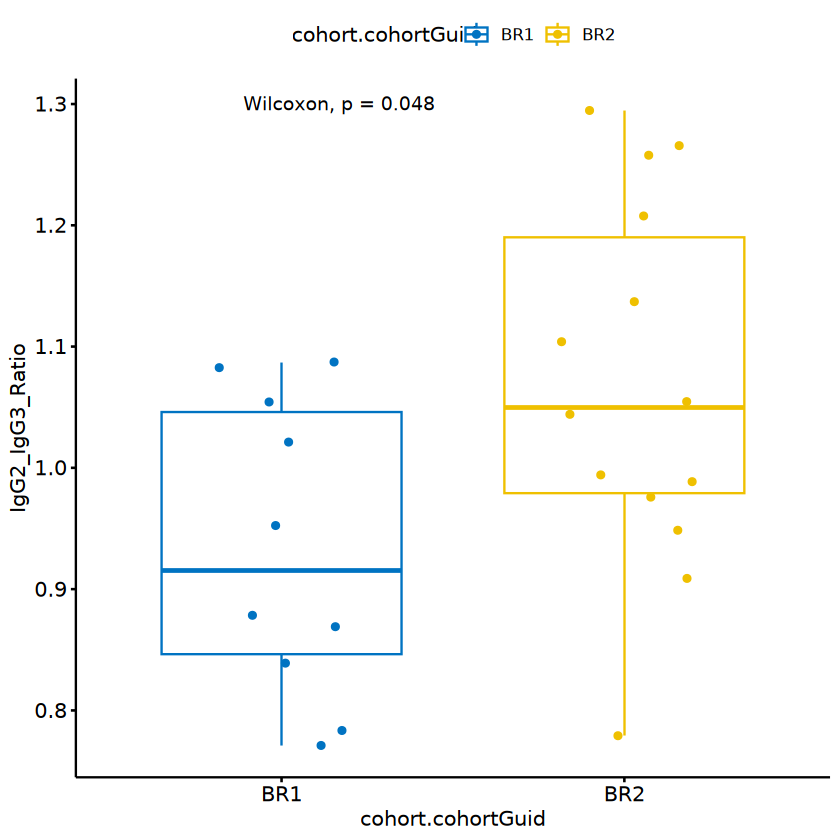

In [55]:
 ggboxplot(df_summay, x = "cohort.cohortGuid", y = "IgG2_IgG3_Ratio",
          color = "cohort.cohortGuid", palette = "jco",
          add = "jitter") + stat_compare_means()